# Fake News Detection
## Natural Language Processing 1st Assignment
### Jean René Espaillat and Martin Louzada

The objective of this assignment is to build a classifier model to detect Fake News. We will apply Natural Laguage Process techniques such as Vectorization, Lemmatization, Tokenization, among others, and try different algorithms to obtain the highest performance in terms of Accuracy.

# Data Loading

In [1]:
# Load packages and libraries
import spacy
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk import NgramTagger
import re
from sklearn.model_selection import GridSearchCV,cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rene\Anaconda3\lib\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rene\Anaconda3\lib\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rene\Anaconda3\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Read data
train = pd.read_csv("fake_or_real_news_training.csv", index_col='ID')
test =  pd.read_csv("fake_or_real_news_test.csv",index_col='ID')

## Data Briefing

In [3]:
train.head()

,title,text,label,X1,X2
ID,,,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [4]:
train.dtypes

title    object
text     object
label    object
X1       object
X2       object
dtype: object

In [5]:
train.isnull().sum()

title       0
text        0
label       0
X1       3966
X2       3997
dtype: int64

Since there are only two values in X2, let's add them to X1 and drop this column.

## Data Cleaning

In [6]:
train.loc[train['X2'].notna(), 'X1'] = train.loc[train['X2'].notna(), 'X2']
train.drop(columns=['X2'], inplace=True)

In [7]:
# Analyze target variable
train.label.value_counts()

REAL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

We can see that there are values in the "label" column that are not FAKE or REAL, so we will identify them and concatenate them to the right text column.

In [8]:
train.loc[(train["label"] != "FAKE") & (train["label"] != "REAL"), "text"] = (
    train.loc[train["X1"].notna(), "label"] + " " + train.loc[train["X1"].notna(), "text"]
)

Now we will impute the misplaced labels values to the right column and drop X1.

In [9]:
train.loc[(train["label"] != "FAKE") & (train["label"] != "REAL"), "label"] = train.loc[
    (train["label"] != "FAKE") & (train["label"] != "REAL"), "X1"
]

train = train.drop(columns='X1')

In [10]:
train.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [11]:
train.label.value_counts() 

REAL    2008
FAKE    1991
Name: label, dtype: int64

## Natural Language Processing

Now let`s perform some Data Cleaning and apply some NLP Pre-Processing techniques:

In [12]:
# Remove Punctuation
import string
train.text = train.text.apply(lambda x: x.translate((str.maketrans('','',string.punctuation))))

# Turn all lower case
train.text = train.text.apply(lambda x: x.strip().lower())

In [13]:
# Tokenization and Lemmatization
# Define a lemmatizer and tokenizer to be called within the vectorizer later
# source: https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, text):
        return [self.wnl.lemmatize(t) for t in word_tokenize(text)]

In [14]:
# TFIDF Vectorization
# TF-IDF stands for Term Frequency-Inverse Document Frequency which tells
# importance of the word in the dataset, reducing the value of the most common words.
tfidf = TfidfVectorizer(stop_words="english",
                        ngram_range=(1,3),
                        max_df=0.7, min_df=2,
                        tokenizer = LemmaTokenizer())
train_tfidf = tfidf.fit_transform(train.text)

C:\Users\Rene\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Here we create a function that uses Spacy to clean the training data for easier use.

In [109]:
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation
def cleanup_text(docs, logging=True):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 300 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [word for word in tokens if word.isalpha()]
        tokens = [word for word in tokens if len(word) > 1]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [112]:
from collections import Counter
# Most common words (Total, Real vs Fake News)
FAKE_text = [text for text in train[train['label'] == 'FAKE']['text']]
REAL_text = [text for text in train[train['label'] == 'REAL']['text']]


print("Start FAKE news Processing:")
FAKE_clean = cleanup_text(FAKE_text)
FAKE_clean = ' '.join(FAKE_clean).split()

print("")

print("Start REAL news Processing")
REAL_clean = cleanup_text(REAL_text)
REAL_clean = ' '.join(REAL_clean).split()


FAKE_counts = Counter(FAKE_clean)
REAL_counts = Counter(REAL_clean)

Start FAKE news Processing:
Processed 300 out of 1991 documents.
Processed 600 out of 1991 documents.
Processed 900 out of 1991 documents.
Processed 1200 out of 1991 documents.
Processed 1500 out of 1991 documents.
Processed 1800 out of 1991 documents.

Start REAL news Processing
Processed 300 out of 2008 documents.
Processed 600 out of 2008 documents.
Processed 900 out of 2008 documents.
Processed 1200 out of 2008 documents.
Processed 1500 out of 2008 documents.
Processed 1800 out of 2008 documents.


## Visualizations

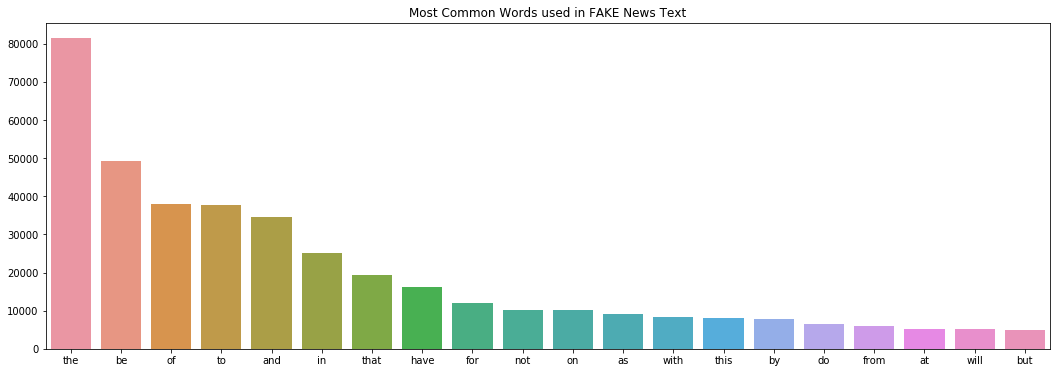

In [97]:
FAKE_common_words = [word[0] for word in FAKE_counts.most_common(20)]
FAKE_common_counts = [word[1] for word in FAKE_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=FAKE_common_words, y=FAKE_common_counts)
plt.title('Most Common Words used in FAKE News Text')
plt.show()

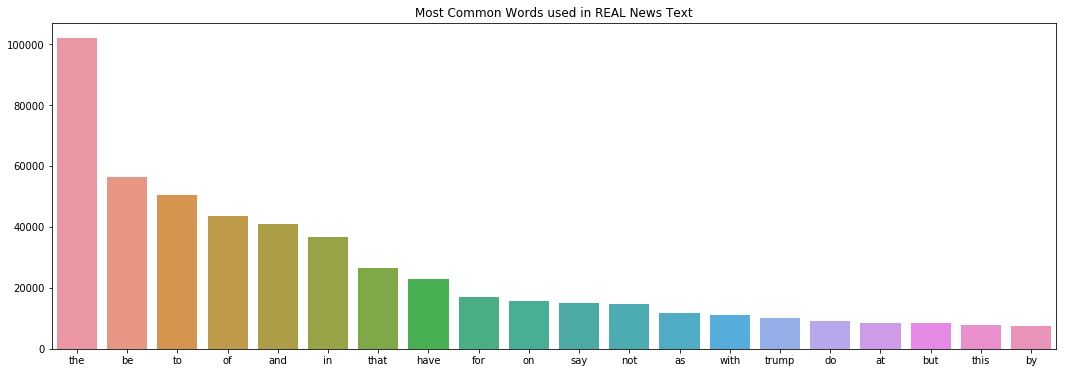

In [98]:
REAL_common_words = [word[0] for word in REAL_counts.most_common(20)]
REAL_common_counts = [word[1] for word in REAL_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=REAL_common_words, y=REAL_common_counts)
plt.title('Most Common Words used in REAL News Text')
plt.show()

With this visualization, we note that the word count in real news is much higher than in fake news. No we are interested in measuring this. Let's check the length of fake news and real new to see if we notice a pattern.

In [116]:
len(FAKE_clean)

1222954

In [115]:
len(REAL_clean)

1597455

The total of objects in real news it longer than fake news.

## Modelling

Let`s separate a validation set out of our training data to evaluate the performance of the different models.

In [15]:
# Train Validation Split
from sklearn.model_selection import train_test_split

X = train_tfidf
y = train.label
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=420)

### Naive-Bayes Model

Now that we have a proper training and validation sets, let`s start training different Text Classification Models: Naive Bayes, Logistic Regression, Support Vector Machine.

Accuracy: 0.8412

              precision    recall  f1-score   support

        FAKE       0.98      0.70      0.82       403
        REAL       0.76      0.99      0.86       397

   micro avg       0.84      0.84      0.84       800
   macro avg       0.87      0.84      0.84       800
weighted avg       0.87      0.84      0.84       800

AxesSubplot(0.125,0.125;0.62x0.755)


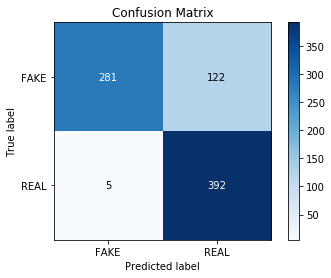

In [16]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
naive = MultinomialNB()
naive_model = naive.fit(X_train, y_train)
naive_preds = naive_model.predict(X_val)
print(f'Accuracy: {round(accuracy_score(y_val, naive_preds),4)}\n')
print(classification_report(y_val, naive_preds))
print(plot_confusion_matrix(y_val, naive_preds))

### Regularized Logistic Regression

Accuracy: 0.915

              precision    recall  f1-score   support

        FAKE       0.90      0.94      0.92       403
        REAL       0.94      0.89      0.91       397

   micro avg       0.92      0.92      0.92       800
   macro avg       0.92      0.91      0.91       800
weighted avg       0.92      0.92      0.91       800

AxesSubplot(0.125,0.125;0.62x0.755)


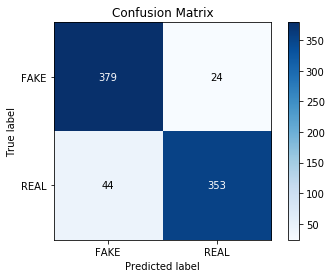

In [17]:
# Regularized Logistic Regression
from sklearn.linear_model import LogisticRegression
reglog = LogisticRegression(solver = "lbfgs", C=1.0)
reglog_model = reglog.fit(X_train, y_train)
reglog_preds = reglog.predict(X_val)
print(f'Accuracy: {round(accuracy_score(y_val, reglog_preds),4)}\n')
print(classification_report(y_val, reglog_preds))
print(plot_confusion_matrix(y_val, reglog_preds))

In [24]:
#Hyperparameter tuning with GridSearchCV
param_grid = {"C":np.logspace(-3,3,7)}

grid_cv_reglog = GridSearchCV(reglog, param_grid, cv=5)
grid_cv_reglog.fit(X_train,y_train)
best_parameters = grid_cv_reglog.best_params_
best_parameters

{'C': 1000.0}

### Optimized Regularized Logistic Regression

Accuracy: 0.9325

             precision    recall  f1-score   support

       FAKE       0.92      0.95      0.93       403
       REAL       0.94      0.92      0.93       397

avg / total       0.93      0.93      0.93       800

AxesSubplot(0.125,0.125;0.62x0.755)


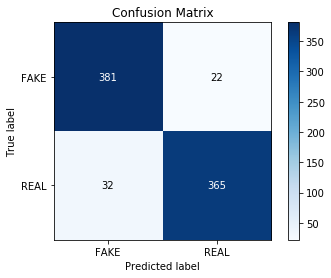

In [98]:
reglog = LogisticRegression(solver = "lbfgs", C=1000.0)
reglog_model = reglog.fit(X_train, y_train)
reglog_preds = reglog.predict(X_val)
print(f'Accuracy: {round(accuracy_score(y_val, reglog_preds),4)}\n')
print(classification_report(y_val, reglog_preds))
print(plot_confusion_matrix(y_val, reglog_preds))

### Support Vector Machine

Accuracy: 0.935

              precision    recall  f1-score   support

        FAKE       0.92      0.95      0.94       403
        REAL       0.95      0.92      0.93       397

   micro avg       0.94      0.94      0.94       800
   macro avg       0.94      0.93      0.93       800
weighted avg       0.94      0.94      0.93       800

AxesSubplot(0.125,0.125;0.62x0.755)


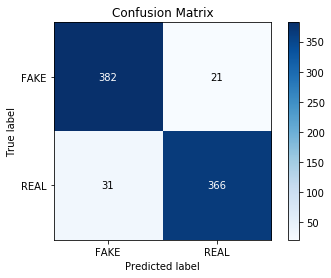

In [18]:
# Support Vector Machine
from sklearn import svm
svm_ = svm.SVC(C=1.0, kernel='linear', gamma='auto')
svm_ = svm_.fit(X_train, y_train)
svm_preds = svm_.predict(X_val)
print(f'Accuracy: {round(accuracy_score(y_val, svm_preds),4)}\n')
print(classification_report(y_val, svm_preds))
print(plot_confusion_matrix(y_val, svm_preds))

In [13]:
#Hyperparameter tuning with GridSearchCV

param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

grid_cv_svm = GridSearchCV(svm, param_grid, cv=5)
grid_cv_svm.fit(X_train,y_train)
best_parameters = grid_cv_svm.best_params_
best_parameters

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

### Optimized Support Vector Machine

Accuracy: 0.9338

              precision    recall  f1-score   support

        FAKE       0.93      0.94      0.93       403
        REAL       0.94      0.92      0.93       397

   micro avg       0.93      0.93      0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800

AxesSubplot(0.125,0.125;0.62x0.755)


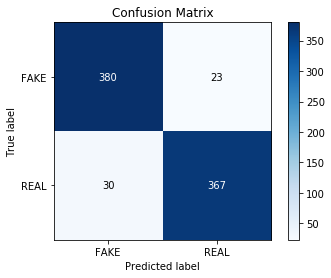

In [19]:
from sklearn import svm
svm = svm.SVC(C=100.0, kernel='rbf', gamma=0.1, degree=3)
svm = svm.fit(X_train, y_train)
svm_preds = svm.predict(X_val)
print(f'Accuracy: {round(accuracy_score(y_val, svm_preds),4)}\n')
print(classification_report(y_val, svm_preds))
print(plot_confusion_matrix(y_val, svm_preds))

The algorithm with the best performance was SVM, even though performance slightly decreased after the hyper parameter optimization. The accuracy however is very similar to Logistic Regression, which is much faster. For this reason, we will use Logistic Regression as our final model.
Before we train our final model with our full data and make predictions on our unlabeled test data, let`s repeat the pre-processing steps with the test set:


In [20]:
# Remove Punctuation
test.text = test.text.apply(lambda x: x.translate((str.maketrans('','',string.punctuation))))

# Turn all lower case
test.text = test.text.apply(lambda x: x.strip().lower())

# TFIDF Vectorization
test_tfidf = tfidf.transform(test.text)

In [21]:
# Train Final Model and make Predictions on Test Set
final_model = LogisticRegression(solver = "lbfgs", C=1000.0)
final_model = final_model.fit(X, y)
test_predictions = svm.predict(test_tfidf)

C:\Users\Rene\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Export

In [22]:
# Export Predictions CSV
submission = pd.DataFrame(test_predictions)
submission.to_csv("NLP_FakeNews_TestPredictions_JR_ML.csv")

## Other NLP methods we tried

Here are some of the methods we attempted while developing this model but were not as efficient as the one we ultimately used because they took much longer to run.

In [1]:
## for token in train['text']:
##    tokenized = nlp(token, parser = DISABLE)
##    print(f"{tokenized.text:{10}} {tokenized.pos_:{10}} {tokenized.dep_:{10}} {tokenized.lemma_}")

## The purpose of this code was to tokenize every text and print each token's text
## along with their respetive POS, dep and lemma.
## You can try running this but it takes a while to run.

## we also attempted to use DISPLACY to visualize the relationships between
## words, but the texts are too many and crashes the notebook.